<a href="https://colab.research.google.com/github/jingjing515/Purchase-Behavior-Analysis/blob/main/Purchase_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 6220 Final Project
## Purchase Behavior Analysis for Targeted Customer Segmentation
### Authors: Jingjing Ma & Jinyan Li



## Import libraries

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import seaborn as sns
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN
from tabulate import tabulate
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D


## Data inspection & cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', delimiter='\t')
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

We will drop rows with missing values in *Income*:





In [ ]:
data = df.dropna(subset=["Income"])

## Feature engineering

The original datasets may not always contain variables that directly reflect the characteristics or behaviors most relevant to our segmentation goals. To enhance our analysis and achieve more meaningful segmentation, we are creating the following features based on the existing data:

* **Total_Num** - Generated from *NumWebPurchases*, *NumCatalogPurchases*, and *NumStorePurchases* by adding the total purchases from all channels for each customer. Frequency can help us estimate customer loyalty and purchasing habits since higher frequency often indicates higher customer loyalty.
* **Total_Mnt** - Generated from *MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds*. Total amount each customer spends across all product categories. Customers with higher spending may receive targeted offers to boost profitability.
* **Age**: Generated from *Year_Birth*, indicates the customer's age.
* **Living_Situation**: Generated from *Marital_Status*, indicates whether a customer lives alone or with a partner. Customers living with partners or families might be interested in different products than those living alone.
* **Num_Children**: Combine *KidHome* and *TeenHome* to get the number of children and teenagers in the household. This can help in marketing family-oriented products and promotions.
* **Is_Parent**: Generated from *KidHome* and *TeenHome* to derive a binary indicator of whether a customer has children or not since parents may have different needs for products.
* **Family_Size**: Combine *Marital_Status* and *Num_Children* to estimate the total number of family members. Different family sizes may lead to needs for different product sizes, categories, and frequencies of purchase.
* **Education**: Simplfiy the education levels into two categories: Undergraduate and Below, Graduate and Above.
* **Campaigns_Accepted**: Generated from *AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Response*. Total number of positive responses to all campaigns.








In [ ]:
data["Total_Num"] = data["NumWebPurchases"] + data["NumCatalogPurchases"] + data["NumStorePurchases"]

data["Total_Mnt"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

data["Age"] = 2024 - data["Year_Birth"]

data['Living_Situation'] = data['Marital_Status'].apply(lambda x: 'With Partner' if x in ['Married', 'Together'] else 'Alone')

data["Num_Children"] = data["Kidhome"] + data["Teenhome"]

data["Is_Parent"] = (data['Num_Children'] > 0).astype(int)

data["Family_Size"] = data['Living_Situation'].apply(lambda x: 2 if x == 'With Partner' else 1) + data['Num_Children']

data["Education"]= data["Education"].replace({"Basic":"Undergraduate_n_Below","2n Cycle":"Undergraduate_n_Below", "Graduation":"Graduate_n_Above", "Master":"Graduate_n_Above", "PhD":"Graduate_n_Above"})

data["Campaigns_Accepted"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"] + data["Response"]

# drop features we no longer need or would not impact our analysis
columns_to_drop = ["Marital_Status", "Year_Birth", "Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response", "ID", "Z_CostContact", "Z_Revenue"]
data = data.drop(columns_to_drop, axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Dt_Customer          2216 non-null   object 
 3   Recency              2216 non-null   int64  
 4   MntWines             2216 non-null   int64  
 5   MntFruits            2216 non-null   int64  
 6   MntMeatProducts      2216 non-null   int64  
 7   MntFishProducts      2216 non-null   int64  
 8   MntSweetProducts     2216 non-null   int64  
 9   MntGoldProds         2216 non-null   int64  
 10  NumDealsPurchases    2216 non-null   int64  
 11  NumWebPurchases      2216 non-null   int64  
 12  NumCatalogPurchases  2216 non-null   int64  
 13  NumStorePurchases    2216 non-null   int64  
 14  NumWebVisitsMonth    2216 non-null   int64  
 15  Complain             2216 non-null   int64 

In [ ]:
data.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,...,5.800993,5.319043,0.009477,12.557310,607.075361,55.179603,0.947202,0.714350,2.592509,0.448556
std,25173.076661,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,...,3.250785,2.425359,0.096907,7.204611,602.900476,11.985554,0.749062,0.451825,0.905722,0.892440
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,28.000000,0.000000,0.000000,1.000000,0.000000
25%,35303.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,3.000000,3.000000,0.000000,6.000000,69.000000,47.000000,0.000000,0.000000,2.000000,0.000000
50%,51381.500000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,...,5.000000,6.000000,0.000000,12.000000,396.500000,54.000000,1.000000,1.000000,3.000000,0.000000
75%,68522.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,...,8.000000,7.000000,0.000000,18.000000,1048.000000,65.000000,1.000000,1.000000,3.000000,1.000000
max,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,...,13.000000,20.000000,1.000000,32.000000,2525.000000,131.000000,3.000000,1.000000,5.000000,5.000000


Next, we want to check if there are any outliers using box plots for *Income*, *Total_Mnt*, and *Age*.

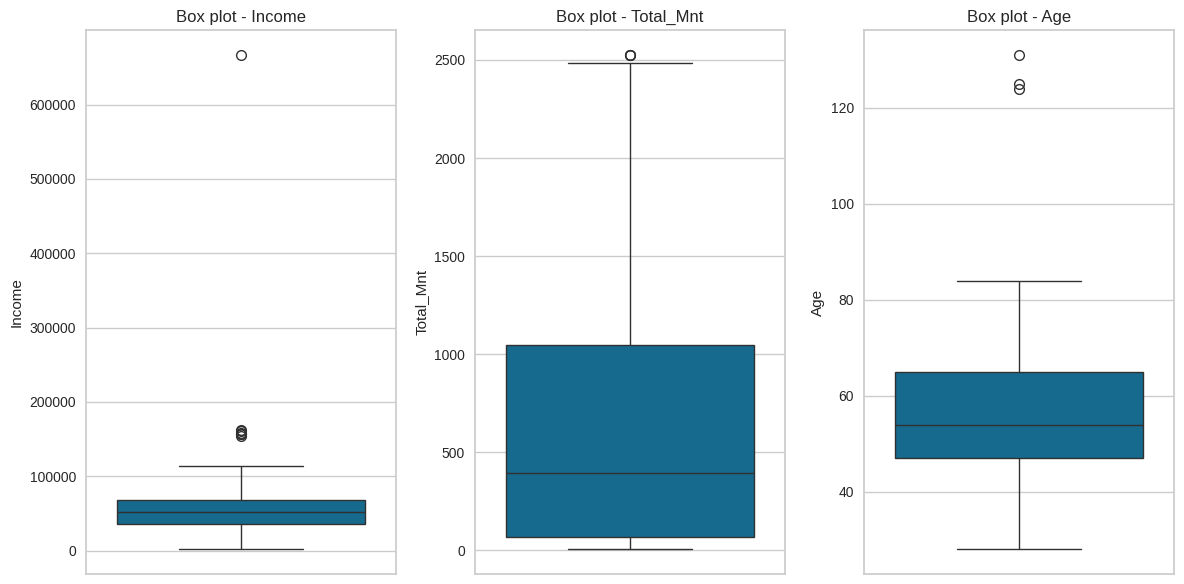

In [ ]:
features_for_box_plots = ['Income', 'Total_Mnt', 'Age']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_for_box_plots, 1):
    plt.subplot(1, len(features_for_box_plots), i)
    sns.boxplot(y=data[feature])
    plt.title(f'Box plot - {feature}')
plt.tight_layout()
plt.show()

We can see from the box plots above, there are some outliers in both *Income* and *Total_Mnt*. Although no clear outliers are visible in the box plot for *Age*, we can see from the stats that the max *Age* in the dataset is 131 because this dataset was collected a long time ago. We are going to set the upper limit of *Age* to 100 and also remove the other outliers.

In [ ]:
selected_columns = ['Income', 'Total_Mnt', 'Age']
Q1 = data[selected_columns].quantile(0.25)
Q3 = data[selected_columns].quantile(0.75)
IQR = Q3 - Q1

# outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter outliers and reset index
data = data[(data["Age"]< 100)]
data = data[(data['Income'] <= upper_bound['Income']) & (data['Income'] >= lower_bound['Income'])]
data = data[(data['Total_Mnt'] <= upper_bound['Total_Mnt']) & (data['Total_Mnt'] >= lower_bound['Total_Mnt'])]
data.reset_index(drop=True, inplace=True)
data.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted
count,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,...,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000
mean,51570.283379,49.021344,304.960036,26.252044,164.336058,37.678474,26.967302,44.014986,2.320163,4.100363,...,5.817893,5.341508,0.009083,12.558583,604.208901,55.124432,0.950045,0.716167,2.595368,0.447775
std,20679.438848,28.944211,336.135586,39.589747,216.312982,54.821185,40.926101,51.747221,1.886763,2.738390,...,3.240334,2.411466,0.094891,7.176459,597.901660,11.687703,0.748922,0.450959,0.905451,0.890786
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,28.000000,0.000000,0.000000,1.000000,0.000000
25%,35182.500000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,3.000000,3.000000,0.000000,6.000000,69.000000,47.000000,0.000000,0.000000,2.000000,0.000000
50%,51258.500000,49.000000,176.500000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,...,5.000000,6.000000,0.000000,12.000000,396.500000,54.000000,1.000000,1.000000,3.000000,0.000000
75%,68146.500000,74.000000,505.000000,33.000000,230.750000,50.000000,33.000000,56.000000,3.000000,6.000000,...,8.000000,7.000000,0.000000,18.000000,1043.750000,65.000000,1.000000,1.000000,3.000000,1.000000
max,113734.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,...,13.000000,20.000000,1.000000,32.000000,2486.000000,84.000000,3.000000,1.000000,5.000000,5.000000


To visually observe and present correlations among features in our dataset, we are going to use a correlation matrix along with a heatmap.

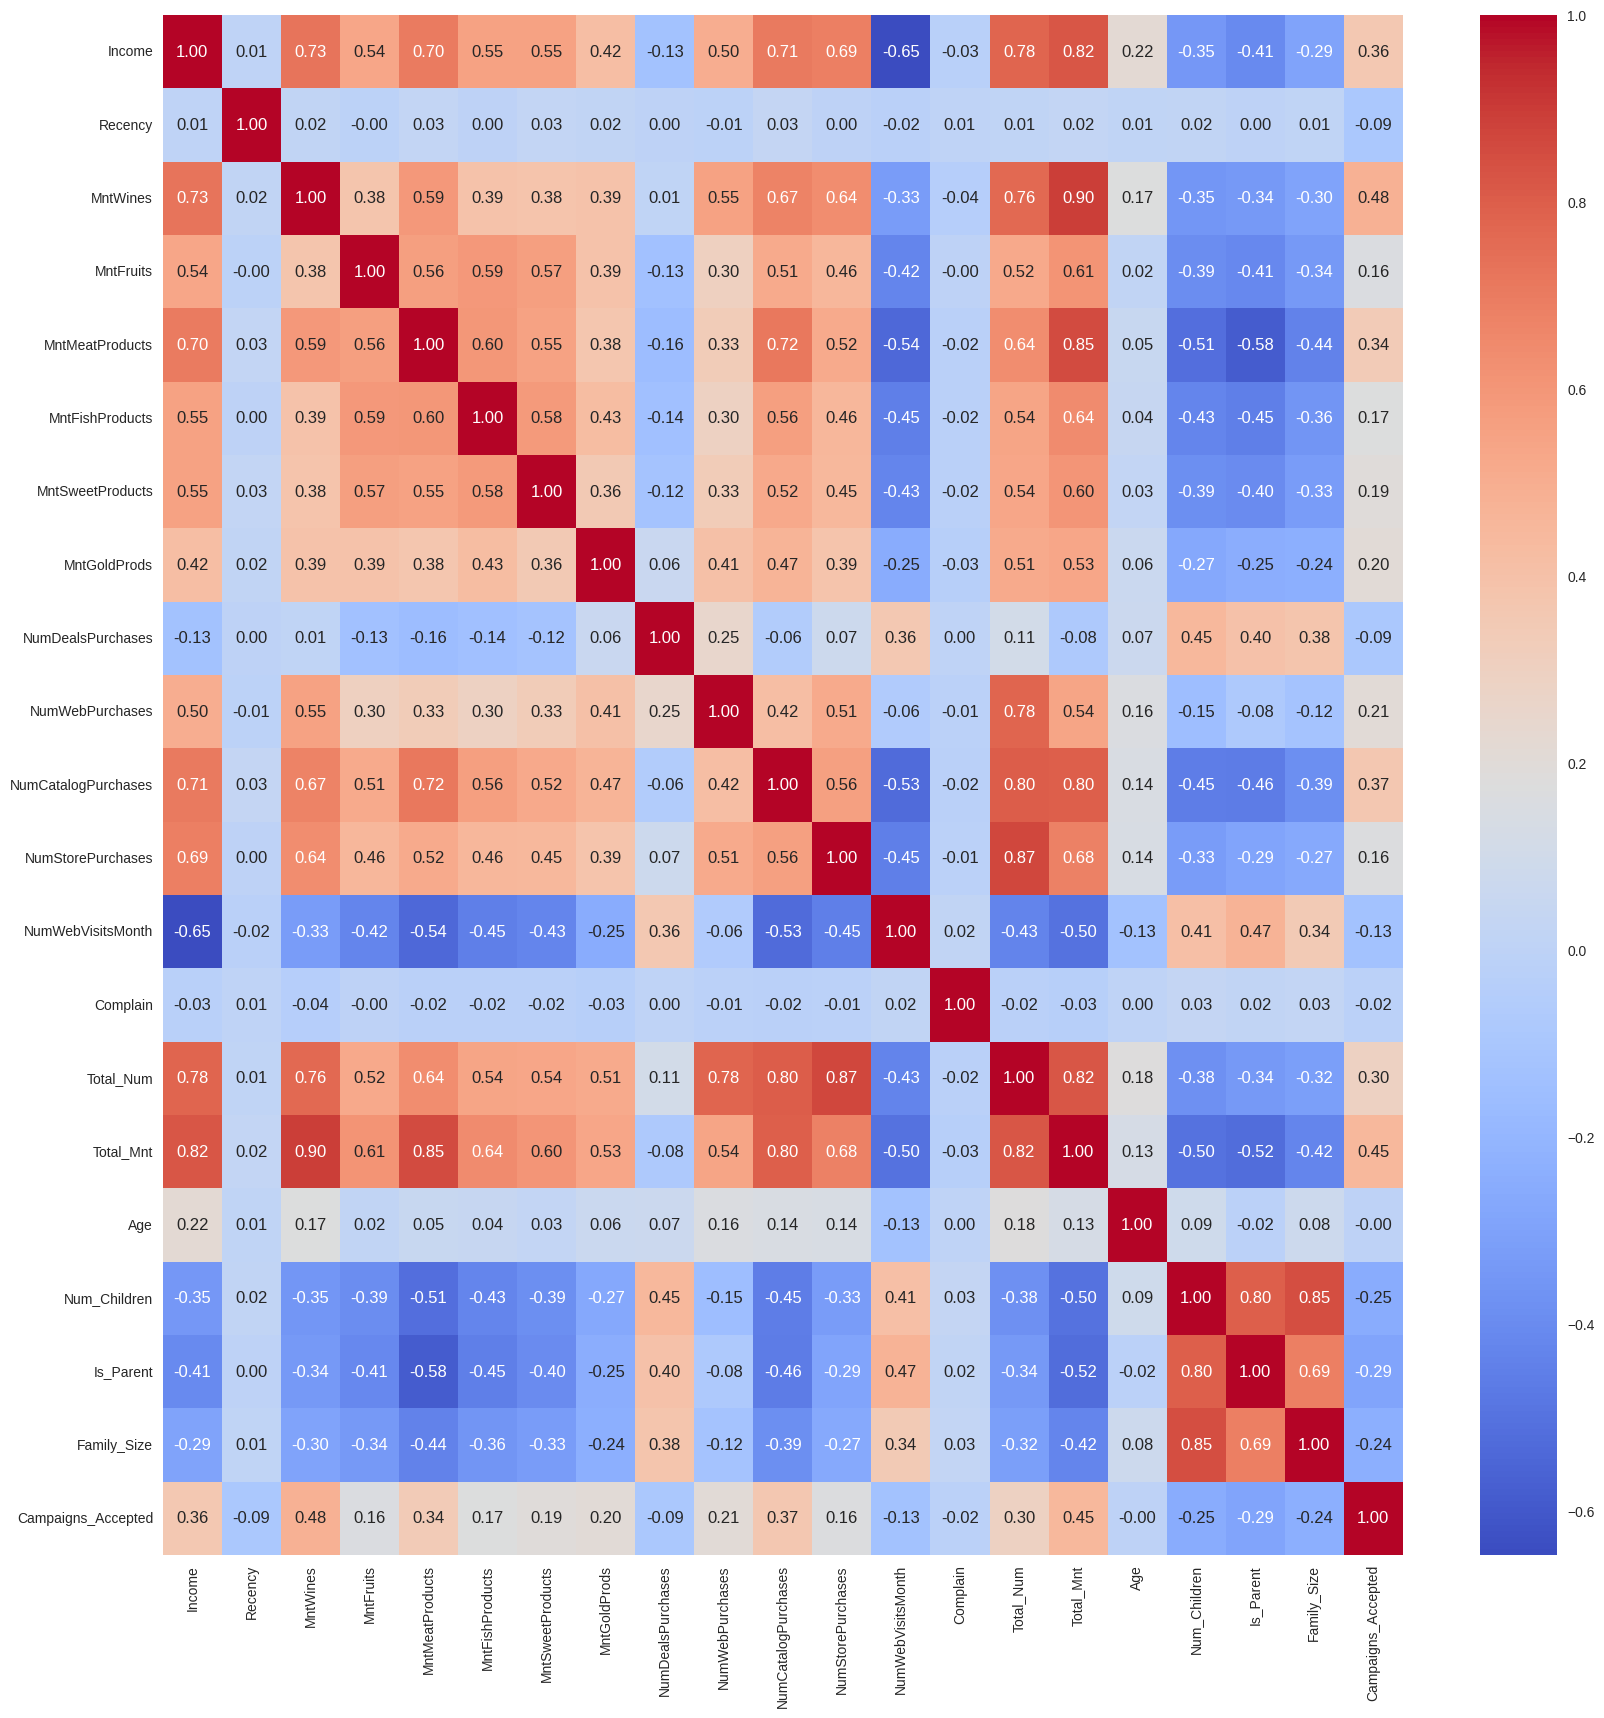

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

From the heat map we can see the following patterns:
- There are strong positive correlations among different spending categories implying that customers who spend more in one category are also likely to spend more in others.
- *Total_Num* is positively correlated with specific channels of purchases showing that customers who purchase more often in one channel tend to have more active purchasing activities overall.
- *NumWebVisitsMonth* is negatively correlated with *NumWebPurchases*, implying that higher website visits do not necessarily result in more purchases.
- *NumDealsPurchases* shows a relatively strong positive correlation with *NumWebPurchases*, suggesting that promotions or discounts might be effective in encouraging online purchases.

## Data preprocessing

Apply standard scaler to ensure each feature's equal contribution and avoiding bias.

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
scaled_data_df = pd.DataFrame(scaled_data, columns=numeric_data.columns)

print("Scaled data frame:")
scaled_data_df.head()

Scaled data frame:


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted
0,0.317669,0.310276,0.982089,1.560050,1.764807,2.450732,1.491629,0.850191,0.360401,1.424385,...,-0.561148,0.687909,-0.095739,1.315908,1.694294,1.016304,-1.268839,-1.588458,-1.762359,0.620071
1,-0.252786,-0.380865,-0.874727,-0.637988,-0.732143,-0.650963,-0.634637,-0.734795,-0.169728,-1.132442,...,-1.178508,-0.141650,-0.095739,-1.192862,-0.965610,1.273043,1.402274,0.629541,0.446986,-0.502788
2,0.969430,-0.795550,0.360174,0.574723,-0.172641,1.337771,-0.145840,-0.038948,-0.699856,1.424385,...,1.290934,-0.556430,-0.095739,1.037156,0.287389,0.331669,-1.268839,-1.588458,-0.657686,-0.502788
3,-1.205543,-0.795550,-0.874727,-0.562193,-0.667407,-0.505001,-0.585757,-0.754125,-0.169728,-0.767181,...,-0.561148,0.273129,-0.095739,-0.914110,-0.922115,-1.294340,0.066717,0.629541,0.446986,-0.502788
4,0.325166,1.554331,-0.392669,0.423134,-0.214257,0.151828,0.000799,-0.560834,1.420658,0.328602,...,0.056213,-0.141650,-0.095739,0.200899,-0.304816,-1.037602,0.066717,0.629541,0.446986,-0.502788


## Dimensionality reduction (PCA)

Now that our data is properly scaled, we can proceed with Principal Component Analysis (PCA).

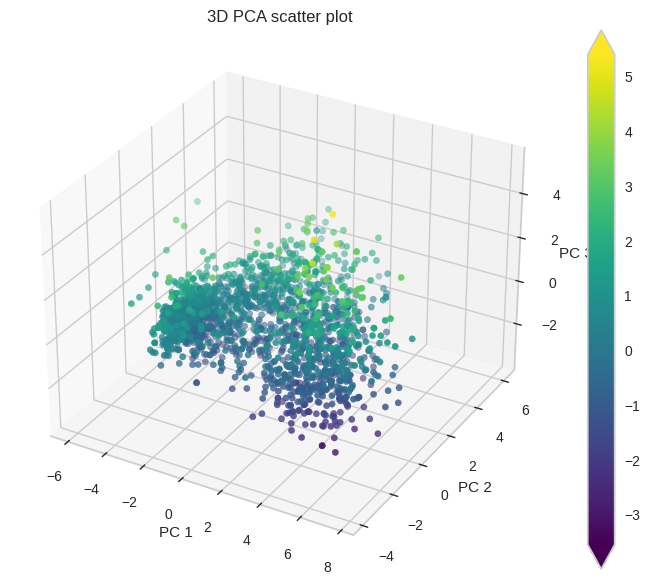

In [ ]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(scaled_data_df)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                     c=data_pca[:, 2], cmap='viridis', marker='o')

colorbar = fig.colorbar(scatter, ax=ax, extend='both')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D PCA scatter plot')

plt.show()

## Hierarchical clustering

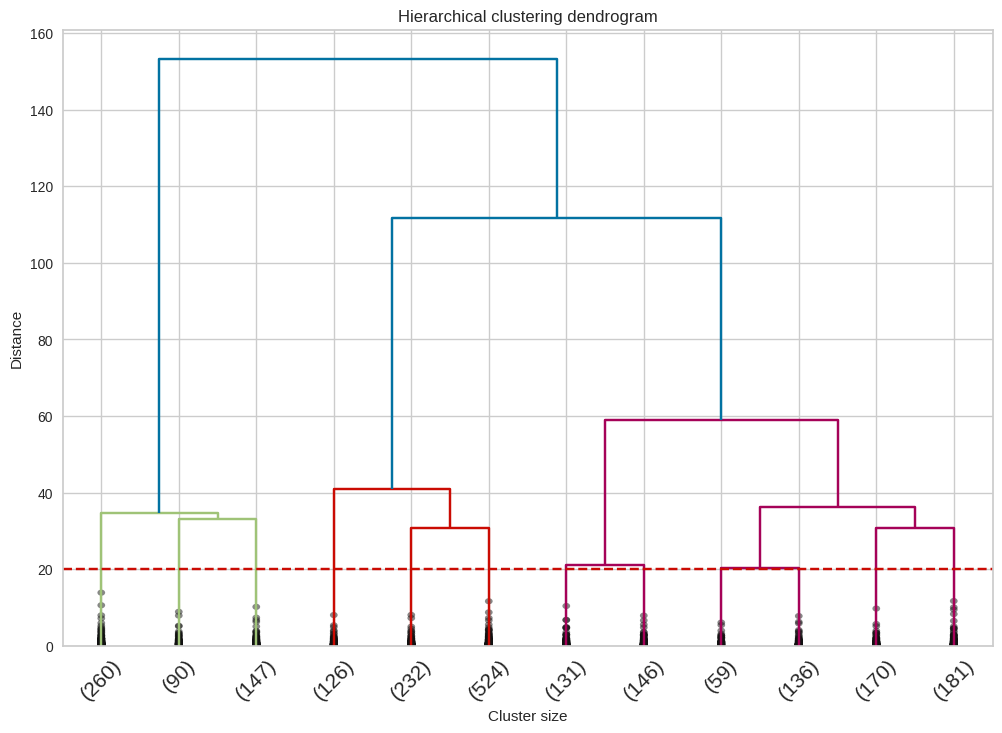

In [ ]:
Z = linkage(data_pca, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z,
           truncate_mode='lastp',
           p=12,
           leaf_rotation=45.,
           leaf_font_size=15.,
           show_contracted=True)
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.axhline(y=20, color='r', linestyle='--')
plt.show()

The dendrogram shows clusters merging at various levels of distance. Some clusters combine at a very high distance, suggesting that these clusters are quite dissimilar compared to others that merge at lower distances.

The distribution of cluster sizes shows a mix of smaller and larger clusters. Some clusters having a substantial number of points (e.g., cluster sizes of 559) and others being very small (sizes like 60). This wide variation in cluster sizes might reflect inherent groupings in the data but could also pose challenges in terms of cluster interpretability.

Due to the varied distances and the uneven cluster sizes, hierarchical clustering might not be the most practical choice for creating customer segments in this case. We will conduct a detailed evaluation to assess its performance.



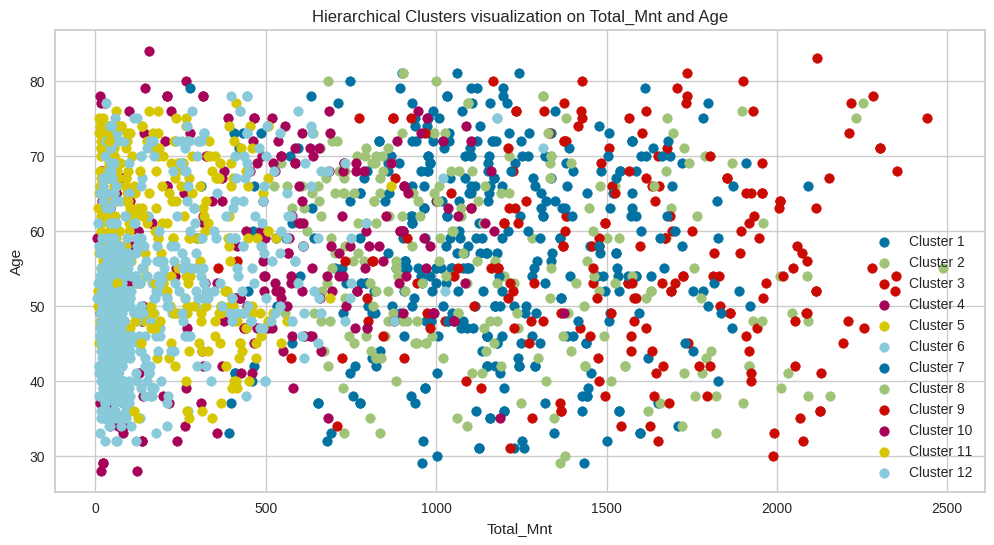

In [ ]:
max_d = 20  # distance cutoff
data['Cluster_H'] = fcluster(Z, max_d, criterion='distance')

plt.figure(figsize=(12, 6))
for i in set(data['Cluster_H']):
    plt.scatter(data.loc[data['Cluster_H'] == i, 'Total_Mnt'], data.loc[data['Cluster_H'] == i, 'Age'], label=f'Cluster {i}')
plt.title('Hierarchical Clusters visualization on Total_Mnt and Age')
plt.xlabel('Total_Mnt')
plt.ylabel('Age')
plt.legend()
plt.show()


**Observations**:

The visualization of the hierarchical clusters shows significant overlapping, indicating that the clusters are not well-separated.

Based on both the dendrogram and the visualization, it appears that hierarchical clustering may not be the best choice for our needs.

We have decided to explore other clustering methods, such as K-means or density-based methods like DBSCAN, which can handle outliers more effectively. These methods might provide more balanced and applicable clusters.

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(scaled_data_df)
data['Cluster_DBSCAN'] = clusters


Cluster counts:
 -1    2202
Name: count, dtype: int64


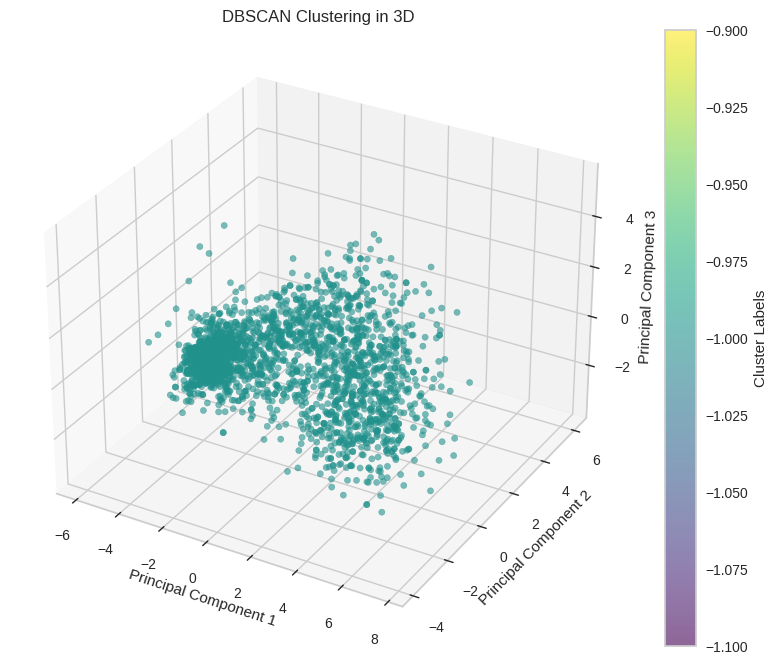

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# count cluster labels to see how many clusters were formed & how many outliers were detected
cluster_counts = pd.Series(clusters).value_counts()
print("Cluster counts:\n", cluster_counts)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# scatter plot using the first three principal components
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                     c=clusters,
                     cmap='viridis',
                     marker='o',
                     alpha=0.6)


colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster Labels')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('DBSCAN Clustering in 3D')

plt.show()


The chart suggests that DBSCAN has identified most of the data as belonging to a single cluster. This indicates that the chosen eps value might not be suitable, leading DBSCAN to consider most points as part of the same cluster.

Next, we will draw a K-Nearest Neighbors Distances plot to find the optimal eps.

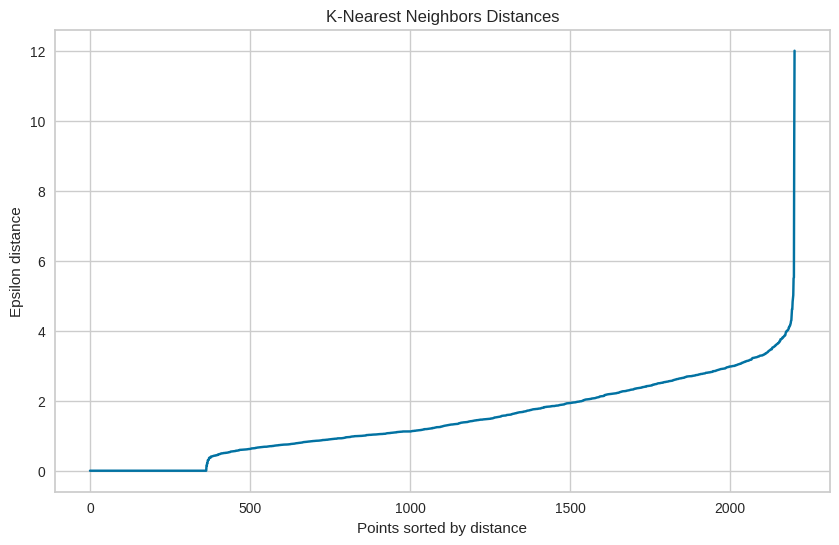

In [ ]:
# use NearestNeighbors to find optimal eps
nn = NearestNeighbors(n_neighbors=2)
nbrs = nn.fit(scaled_data_df)
distances, indices = nbrs.kneighbors(scaled_data_df)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Nearest Neighbors Distances')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.show()


According to the polt, we can observe a sudden inscrease shows around 4, so the optimal eps should be 4.

Cluster counts:
  0    2153
-1      38
 1      11
Name: count, dtype: int64


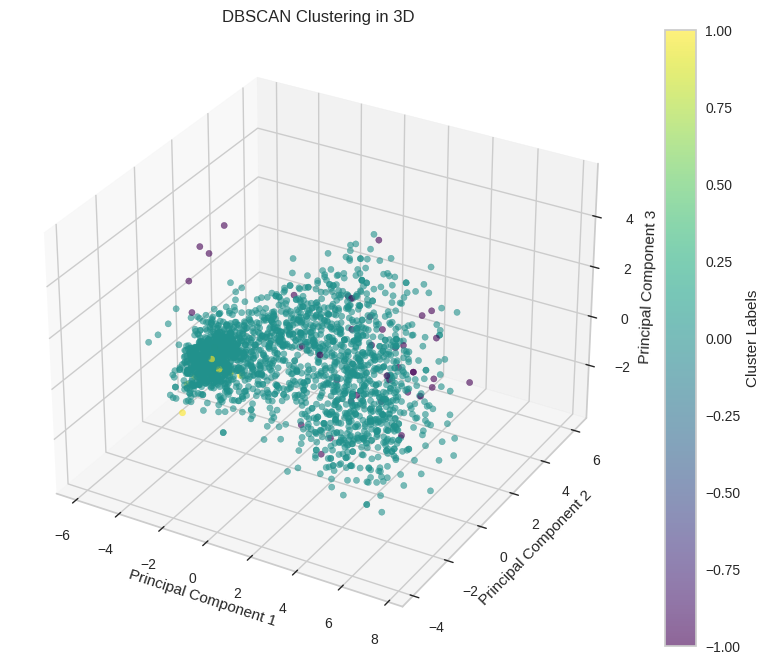

In [ ]:
# update eps
dbscan = DBSCAN(eps=4, min_samples=5)
clusters = dbscan.fit_predict(scaled_data_df)

# count cluster labels to see how many clusters were formed & how many outliers were detected
cluster_counts = pd.Series(clusters).value_counts()
print("Cluster counts:\n", cluster_counts)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# scatter plot using the first three principal components
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                     c=clusters,
                     cmap='viridis',
                     marker='o',
                     alpha=0.6)


colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster Labels')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('DBSCAN Clustering in 3D')

plt.show()

According to the plot, the majority of data points are still identified as part of one large cluster. This could indicate that the data does not contain distinct, dense regions required by DBSCAN. It's better to consider other clustering methods.


## K-means clustering

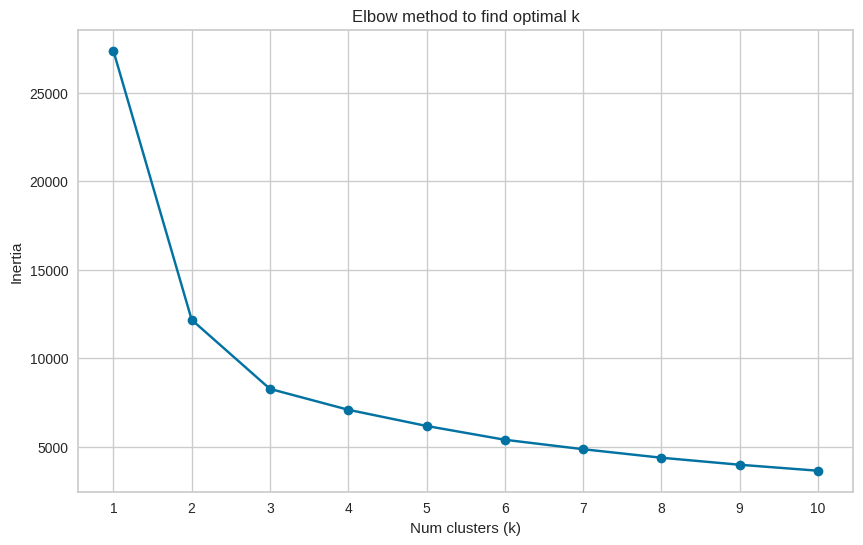

In [ ]:
k_values = range(1, 11)
inertias = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_pca)
    inertias.append(model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, '-o')
plt.title('Elbow method to find optimal k')
plt.xlabel('Num clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Based on the elbow method graph, we pick k=3 for clustering because it's where the decrease in inertia starts to level off, suggesting that three clusters are enough to capture the main structure of the data without adding unnecessary complexity.

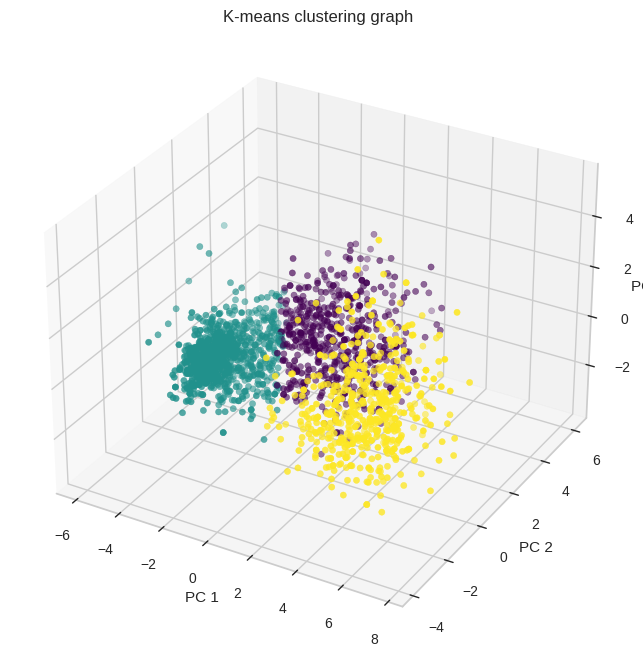

In [ ]:
# choose the optimal k from the elbow curve
k_optimal = 3

# apply K-Means to the dataset
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(data_pca)

data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
data_pca_df['Cluster'] = cluster_labels

fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca_df['PC1'], data_pca_df['PC2'], data_pca_df['PC3'], c=data_pca_df['Cluster'], cmap='viridis')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('K-means clustering graph')
plt.show()

### Evaluating the Graph:

In the graph, each cluster shows different levels of density which is common in complex data. The teal cluster stands out because it seems to include a special kind of customers with unique traits or behaviors that set them apart from others.

The purple and yellow clusters overlap a bit but we can still tell them apart. This overlap suggests that these groups share some characteristics but also have their own unique features, as shown by the analysis methods we used.

Overall, the groups are mostly well-separated, which is great for our purpose of customer segmentation. The small overlaps are normal and show that there are subtle connections between the customer groups, which we'll explore further.

Next, we'll use numerical analysis to measure how far apart these groups are. This step will confirm what we see in the graph and help us come up with marketing strategies based on these segments.



Cluster Summary:


,Cluster,Income,Total_Mnt,Age,Total_Num,Num_Children,Family_Size,Campaigns_Accepted
0,0,60121.541237,813.835052,58.676976,18.037801,1.209622,2.903780,0.419244
1,1,35159.585028,109.334566,52.874307,6.195933,1.231054,2.878928,0.172828
2,2,75324.081784,1372.706320,55.806691,19.427509,0.104089,1.691450,1.031599


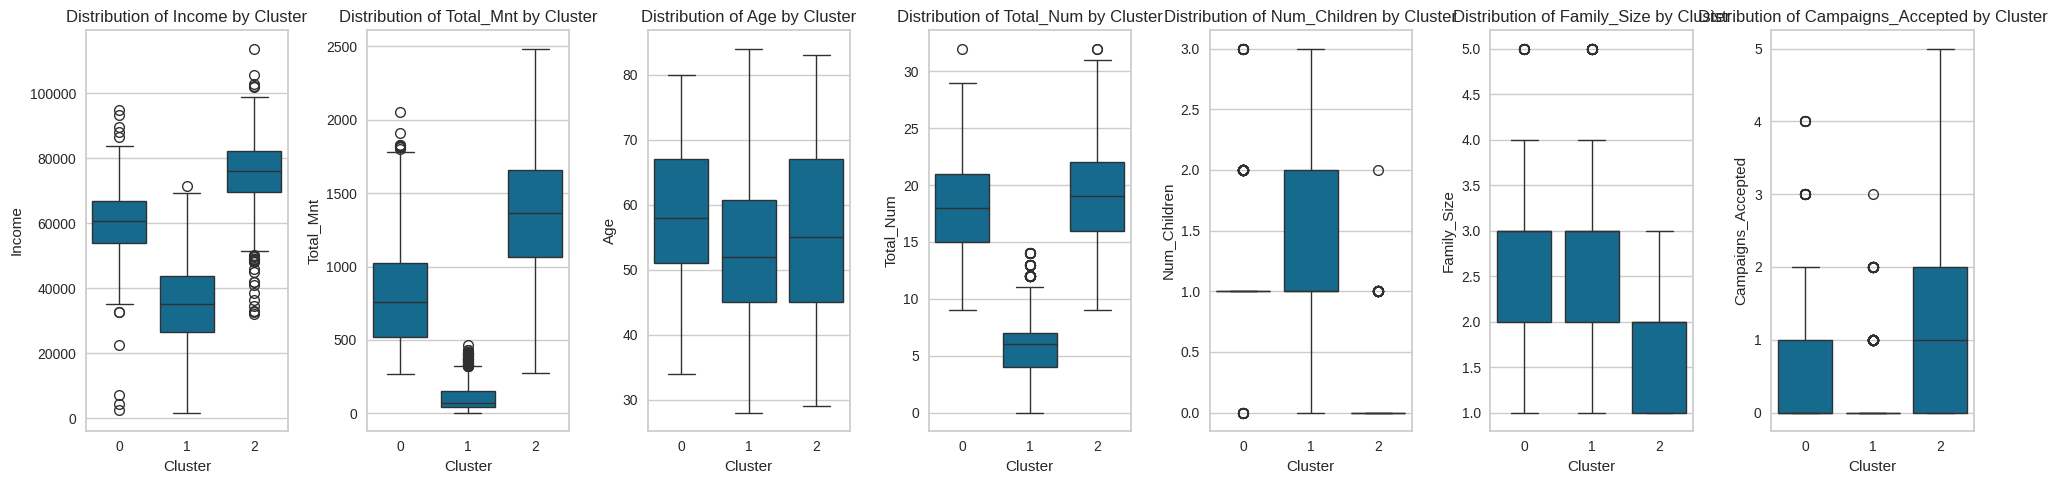

Detailed examination by cluster:

Cluster 0:


,PC1,PC2,PC3,Cluster,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted,Cluster_H,Cluster_DBSCAN
count,582.000000,582.000000,582.000000,582.0,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,...,582.000000,582.000000,582.000000,582.000000,582.000000,582.00000,582.000000,582.000000,582.000000,582.0
mean,0.793074,1.802879,0.101823,0.0,60121.541237,48.281787,493.312715,29.108247,159.646048,37.104811,...,0.010309,18.037801,813.835052,58.676976,1.209622,0.98110,2.903780,0.419244,9.225086,-1.0
std,1.343986,1.104372,1.166521,0.0,11057.375060,28.127990,283.238486,35.187283,123.962247,44.065602,...,0.101097,4.048154,348.080931,9.778024,0.498580,0.13629,0.689997,0.769138,2.082429,0.0
min,-2.568538,-1.580492,-3.548849,0.0,2447.000000,0.000000,1.000000,0.000000,12.000000,0.000000,...,0.000000,9.000000,265.000000,34.000000,0.000000,0.00000,1.000000,0.000000,1.000000,-1.0
25%,-0.213990,1.072468,-0.754870,0.0,53977.000000,25.000000,284.000000,5.000000,80.000000,7.000000,...,0.000000,15.000000,522.000000,51.000000,1.000000,1.00000,2.000000,0.000000,8.000000,-1.0
50%,0.764397,1.723999,0.077867,0.0,60569.500000,49.000000,424.500000,16.000000,134.000000,20.000000,...,0.000000,18.000000,757.500000,58.000000,1.000000,1.00000,3.000000,0.000000,10.000000,-1.0
75%,1.811718,2.380252,0.801381,0.0,66729.750000,70.750000,640.500000,42.000000,214.750000,54.000000,...,0.000000,21.000000,1026.750000,67.000000,1.000000,1.00000,3.000000,1.000000,11.000000,-1.0
max,4.367972,6.094485,3.615041,0.0,94871.000000,99.000000,1486.000000,199.000000,1725.000000,258.000000,...,1.000000,32.000000,2053.000000,80.000000,3.000000,1.00000,5.000000,4.000000,12.000000,-1.0



Cluster 1:


,PC1,PC2,PC3,Cluster,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted,Cluster_H,Cluster_DBSCAN
count,1082.000000,1082.000000,1082.000000,1082.0,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,...,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.0
mean,-2.499938,-0.517708,-0.024916,1.0,35159.585028,49.082255,49.361368,5.273567,25.186691,7.852126,...,0.010166,6.195933,109.334566,52.874307,1.231054,0.878928,2.878928,0.172828,6.490758,-1.0
std,0.870750,1.201900,0.808751,0.0,12395.974532,29.082384,60.907064,8.074985,26.268455,13.076178,...,0.100361,2.665166,98.635261,11.066735,0.699039,0.326362,0.843509,0.457926,2.404207,0.0
min,-5.935742,-3.872142,-2.609871,1.0,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.0
25%,-3.103921,-1.218932,-0.565319,1.0,26366.250000,24.000000,8.000000,1.000000,8.000000,1.000000,...,0.000000,4.000000,40.000000,45.000000,1.000000,1.000000,2.000000,0.000000,5.000000,-1.0
50%,-2.703190,-0.500078,-0.054026,1.0,35212.000000,49.000000,23.000000,3.000000,15.500000,3.000000,...,0.000000,6.000000,68.000000,52.000000,1.000000,1.000000,3.000000,0.000000,6.000000,-1.0
75%,-2.005342,0.270279,0.443776,1.0,43742.250000,75.000000,67.000000,6.000000,31.000000,10.000000,...,0.000000,7.000000,152.750000,60.750000,2.000000,1.000000,3.000000,0.000000,6.000000,-1.0
max,0.753920,3.635672,3.317876,1.0,71322.000000,99.000000,309.000000,65.000000,217.000000,150.000000,...,1.000000,14.000000,467.000000,84.000000,3.000000,1.000000,5.000000,3.000000,12.000000,-1.0



Cluster 2:


,PC1,PC2,PC3,Cluster,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Total_Num,Total_Mnt,Age,Num_Children,Is_Parent,Family_Size,Campaigns_Accepted,Cluster_H,Cluster_DBSCAN
count,538.000000,538.000000,538.000000,538.0,538.000000,538.000000,538.000000,538.00000,538.000000,538.000000,...,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.00000,538.000000,538.000000,538.0
mean,4.169821,-0.909137,-0.060041,2.0,75324.081784,49.698885,615.250929,65.35316,449.260223,98.284387,...,0.005576,19.427509,1372.706320,55.806691,0.104089,0.102230,1.69145,1.031599,2.444238,-1.0
std,1.291334,1.008737,1.481447,0.0,11134.485156,29.564978,319.829532,50.25827,231.080571,66.334285,...,0.074535,4.205094,426.371363,13.622053,0.311693,0.303233,0.57376,1.302099,2.070826,0.0
min,0.771214,-2.903528,-3.178708,2.0,31907.000000,0.000000,6.000000,0.00000,3.000000,0.000000,...,0.000000,9.000000,277.000000,29.000000,0.000000,0.000000,1.00000,0.000000,1.000000,-1.0
25%,3.342081,-1.607810,-1.080242,2.0,69675.500000,23.000000,369.000000,25.00000,265.000000,42.000000,...,0.000000,16.000000,1067.500000,45.000000,0.000000,0.000000,1.00000,0.000000,1.000000,-1.0
50%,4.143103,-1.092961,-0.281074,2.0,76110.500000,53.500000,567.500000,51.00000,419.500000,86.000000,...,0.000000,19.000000,1363.500000,55.000000,0.000000,0.000000,2.00000,1.000000,2.000000,-1.0
75%,5.008495,-0.466535,0.804750,2.0,82300.500000,74.000000,834.500000,98.00000,602.750000,149.000000,...,0.000000,22.000000,1661.000000,67.000000,0.000000,0.000000,2.00000,2.000000,3.000000,-1.0
max,7.631096,2.970805,5.404482,2.0,113734.000000,99.000000,1493.000000,197.00000,984.000000,259.000000,...,1.000000,32.000000,2486.000000,83.000000,2.000000,1.000000,3.00000,5.000000,9.000000,-1.0


In [ ]:
# add original features back to the PCA DataFrame for interpretation
data_pca_df = pd.concat([data_pca_df, data.reset_index(drop=True)], axis=1)

# calculate average values for important features
cluster_summary = data_pca_df.groupby('Cluster').agg({
    'Income': 'mean',
    'Total_Mnt': 'mean',
    'Age': 'mean',
    'Total_Num': 'mean',
    'Num_Children': 'mean',
    'Family_Size': 'mean',
    'Campaigns_Accepted': 'mean'
}).reset_index()

print("Cluster Summary:")
display(cluster_summary)

# visualize the distribution of key features
features_to_visualize = ['Income', 'Total_Mnt', 'Age', 'Total_Num', 'Num_Children', 'Family_Size','Campaigns_Accepted']
fig, axes = plt.subplots(1, len(features_to_visualize), figsize=(20, 5))
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(ax=axes[i], x='Cluster', y=feature, data=data_pca_df)
    axes[i].set_title(f'Distribution of {feature} by Cluster')
plt.tight_layout()
plt.show()

# examine specific behaviors
print("Detailed examination by cluster:")
for i in range(k_optimal):
    print(f"\nCluster {i}:")
    display(data_pca_df[data_pca_df['Cluster'] == i].describe())


## Evaluating models

### Metrics

#### Silhouette Score

The Silhouette Score ranges from -1 to 1. A high score near +1 indicates that the clusters are well apart from each other and clearly defined.

#### Calinski-Harabasz Score

This score is higher when clusters are dense and well-separated, which relates to a model with better-defined clusters.

#### Davies-Bouldin Score

The Davies-Bouldin Score reflects the average 'similarity' between clusters. Similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Lower values indicate better clustering.

In [ ]:
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(data_pca_df)

silhouette = silhouette_score(data_pca_df, cluster_labels)
calinski_harabasz = calinski_harabasz_score(data_pca_df, cluster_labels)
davies_bouldin = davies_bouldin_score(data_pca_df, cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Silhouette Score: 0.44358596566379327
Calinski-Harabasz Index: 2545.5915666907495
Davies-Bouldin Index: 0.890347332318122


### Results

#### Silhouette Score: 0.443

A score of 0.443 is moderate, suggesting that the clusters are reasonably well-separated but not distinct. This score indicates a moderate separation among our customer clusters. While the customer groups are reasonably distinguishable, the score suggests some overlap and this is expected in a diverse customer base. This indicates we are effectively identifying distinct customer behaviors but also highlights the complexity of customer preferences.

#### Calinski-Harabasz Index: 2545.553

The high value of this index confirms that our customer segmentation is good, showing that each segment is internally cohesive while being distinct from others. This strong separation supports our strategy to tailor marketing efforts according to the specific characteristics and needs of each segment.

#### Davies-Bouldin Index: 0.891

Although lower values would be ideal, this score still reflects fairly well-separated clusters. It confirms that our segments are distinct enough to warrant customized marketing approaches for each, enabling more targeted and effective marketing campaigns.

#### Overall Assessment:

The clustering analysis, both visual and numerical, confirms that the K-means algorithm has performed effectively. The clusters identified through the algorithm are generally distinct and separate well. The K-means algorithm has effectively grouped customers into distinct categories.

## Profiling

The box plots reveal distinct patterns among the three clusters, helping us understand the unique characteristics of each customer group.

### Cluster 0: Active shoppers

High-income earners with significant spending on products, fewer children, and typically smaller family sizes. They engage in a high number of transactions, suggesting active purchasing behavior. This cluster is also the most responsive to marketing efforts.

Suggested Strategy:

1. Focus on high-end products
2. Implement loyalty programs with exclusive benefits
3. Create personalized marketing campaigns that highlight premium service and product quality

### Cluster 1: Cost-conscious buyers

Lower-income customers characterized by the lowest levels of spending and transaction numbers, possibly younger or facing more constraints on discretionary spending.

Suggested Strategy:

1. Target with discounts and bulk purchase deals
2. Offer financial services or payment plans to encourage purchasing

### Cluster 2: Family shoppers

Middle-income earners with moderate spending and transaction activity, but slightly larger family sizes and a moderate response to marketing campaigns.

Suggested Strategy:

1. Promote products that appeal to larger families.
2. Focus on promotions for kid- and teen-friendly products.
3. Organize campaigns centered around holidays or family events.

### Conclusion
By tailoring our marketing strategies to the specific needs and characteristics of each cluster, we can improve customer engagement and drive sales more effectively. Each cluster's distinct profile suggests targeted approaches that align with their unique preferences and financial capacities.

